### Importing Data through keras library

In [1]:
from tensorflow.keras.datasets import imdb
import numpy as np

vocabulary_size = 4000 
n = 100  # Αριθμός πιο συχνών λέξεων που θα αφαιρεθούν
k = 50   # Αριθμός πιο σπάνιων λέξεων που θα αφαιρεθούν
m = 3000 # Αριθμός λέξεων με το υψηλότερο πληροφοριακό κέρδος

# Load the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocabulary_size)
word_index = imdb.get_word_index() # dictionary mapping words to their corresponding integer indices
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Create a Vocabulary

In [2]:
from collections import Counter

vocabulary = Counter()
for text in x_train_text:
    tokens = text.split()
    vocabulary.update(tokens)

most_common_words = [word for word, _ in vocabulary.most_common(n)]
least_common_words = [word for word, _ in vocabulary.most_common()[:-k-1:-1]]

filtered_vocabulary = [word for word in vocabulary.keys() 
                       if word not in most_common_words and word not in least_common_words]

filtered_vocabulary = list(filtered_vocabulary)


### Create Binary Vectors

In [25]:
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_classif

def create_binary_vectors(texts, vocabulary):
  binary_vectors = []

  for text in tqdm(texts):
    tokens = text.split()
    b_vector = list()
    for vocab_token in vocabulary:
      if vocab_token in tokens:
        b_vector.append(1)
      else:
        b_vector.append(0)
    binary_vectors.append(b_vector)

  return np.array(binary_vectors)

x_train_binary = create_binary_vectors(x_train_text, filtered_vocabulary)

# πληροφοριακο κερδος
mutual_info = mutual_info_classif(x_train_binary, y_train, discrete_features=True)
# Επιλογή m λέξεων με το υψηλότερο πληροφοριακό κέρδος
top_m_indices = np.argsort(mutual_info)[-m:]
final_vocabulary = [filtered_vocabulary[i] for i in top_m_indices]

# Μετατροπή των δεδομένων σε διανύσματα βάσει του τελικού λεξιλογίου
x_train_binary_final = create_binary_vectors(x_train_text, final_vocabulary)
x_test_binary_final = create_binary_vectors(x_test_text, final_vocabulary)

100%|██████████| 25000/25000 [02:27<00:00, 169.70it/s]


In [26]:
class BernoulliNaiveBayes:
    def __init__(self):
        self.class_priors = {}  # Prior P(C)
        self.feature_probs = {}  # Likelihood P(X | C)

    def fit(self, X, y):
        """
        Train the Bernoulli Naive Bayes classifier.
        :param X: Binary feature matrix (num_samples, num_features)
        :param y: Labels (num_samples,)
        """
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        # Calculate priors P(C)
        for cls in unique_classes:
            class_count = np.sum(y == cls)
            self.class_priors[cls] = class_count / n_samples

        # Calculate likelihoods P(X | C)
        for cls in unique_classes:
            # Select samples belonging to this class
            X_class = X[y == cls]
            # Compute probabilities for each feature
            feature_prob = (np.sum(X_class, axis=0) + 1) / (X_class.shape[0] + 2)  # Laplace smoothing
            self.feature_probs[cls] = feature_prob

    def predict(self, X):
        """
        Predict the class for each sample in X.
        :param X: Binary feature matrix (num_samples, num_features)
        :return: Predicted labels
        """
        predictions = []

        for x in X:
            class_scores = {}
            for cls in self.class_priors:
                # Start with the log prior
                score = np.log(self.class_priors[cls])

                # Add the log likelihoods
                feature_prob = self.feature_probs[cls]
                score += np.sum(np.log(feature_prob) * x + np.log(1 - feature_prob) * (1 - x))
                class_scores[cls] = score

            # Choose the class with the highest score
            predictions.append(max(class_scores, key=class_scores.get))

        return np.array(predictions)


# Training the Bernoulli Naive Bayes classifier
nb_classifier = BernoulliNaiveBayes()
nb_classifier.fit(x_train_binary_final, y_train)

# Testing the classifier
y_pred = nb_classifier.predict(x_test_binary_final)

# Evaluate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.2f}")

x_train_binary_final shape: (25000, 3000)
y_train shape: (25000,)
Accuracy: 0.85


x_train_binary_final shape: (25000, 3000)
y_train shape: (25000,)
x_train_binary_final shape: (25000, 3000)
y_train shape: (25000,)
x_train_binary_final shape: (25000, 3000)
y_train shape: (25000,)
x_train_binary_final shape: (25000, 3000)
y_train shape: (25000,)
x_train_binary_final shape: (25000, 3000)
y_train shape: (25000,)
x_train_binary_final shape: (25000, 3000)
y_train shape: (25000,)
x_train_binary_final shape: (25000, 3000)
y_train shape: (25000,)
x_train_binary_final shape: (25000, 3000)
y_train shape: (25000,)
x_train_binary_final shape: (25000, 3000)
y_train shape: (25000,)
x_train_binary_final shape: (25000, 3000)
y_train shape: (25000,)


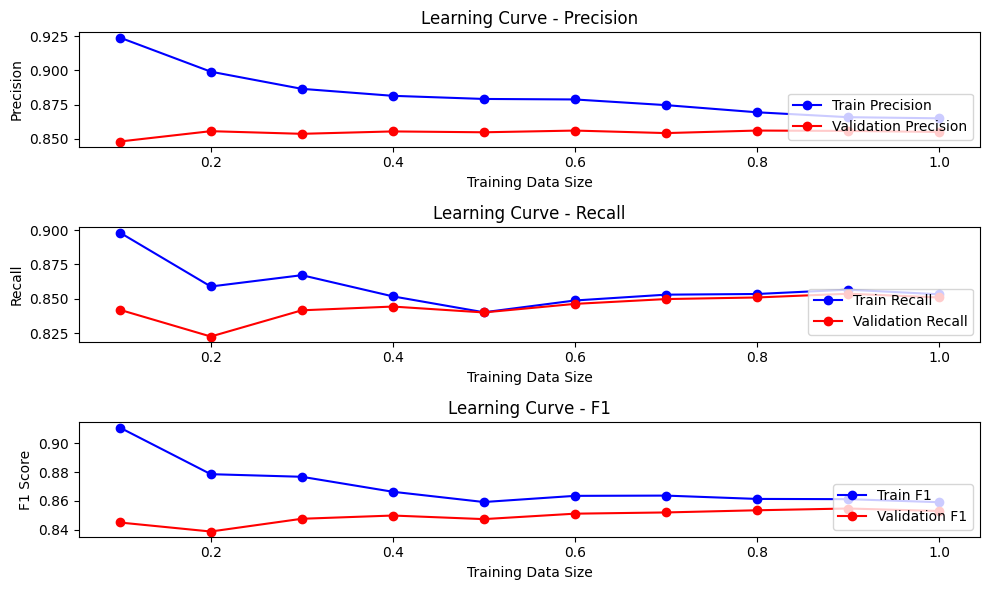

x_train_binary_final shape: (25000, 3000)
y_train shape: (25000,)
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Precision, Recall, F1 for each class (Test Data):
Class 0: Precision: 0.84, Recall: 0.86, F1: 0.85
Class 1: Precision: 0.85, Recall: 0.83, F1: 0.84

Micro-Averaged Precision: 0.85
Micro-Averaged Recall: 0.85
Micro-Averaged F1: 0.85
Macro-Averaged Precision: 0.85
Macro-Averaged Recall: 0.85
Macro-Averaged F1: 0.85


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Helper function for plotting
def plot_learning_curve(train_sizes, train_precision, train_recall, train_f1, val_precision, val_recall, val_f1):
    plt.figure(figsize=(10, 6))
    
    # Plot Precision
    plt.subplot(3, 1, 1)
    plt.plot(train_sizes, train_precision, label='Train Precision', color='blue', marker='o')
    plt.plot(train_sizes, val_precision, label='Validation Precision', color='red', marker='o')
    plt.xlabel('Training Data Size')
    plt.ylabel('Precision')
    plt.legend(loc='lower right')
    plt.title('Learning Curve - Precision')
    
    # Plot Recall
    plt.subplot(3, 1, 2)
    plt.plot(train_sizes, train_recall, label='Train Recall', color='blue', marker='o')
    plt.plot(train_sizes, val_recall, label='Validation Recall', color='red', marker='o')
    plt.xlabel('Training Data Size')
    plt.ylabel('Recall')
    plt.legend(loc='lower right')
    plt.title('Learning Curve - Recall')
    
    # Plot F1
    plt.subplot(3, 1, 3)
    plt.plot(train_sizes, train_f1, label='Train F1', color='blue', marker='o')
    plt.plot(train_sizes, val_f1, label='Validation F1', color='red', marker='o')
    plt.xlabel('Training Data Size')
    plt.ylabel('F1 Score')
    plt.legend(loc='lower right')
    plt.title('Learning Curve - F1')
    
    plt.tight_layout()
    plt.show()

# Function for calculating precision, recall, and F1 score for learning curves
def calculate_metrics_for_curve(model, X_train, y_train, X_val, y_val):
    # Make predictions for training data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_precision = precision_score(y_train, y_train_pred)
    val_precision = precision_score(y_val, y_val_pred)
    
    train_recall = recall_score(y_train, y_train_pred)
    val_recall = recall_score(y_val, y_val_pred)
    
    train_f1 = f1_score(y_train, y_train_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    
    return train_precision, train_recall, train_f1, val_precision, val_recall, val_f1

# Initialize model
nb_classifier = BernoulliNaiveBayes()

# Initialize arrays to store metrics
train_sizes = np.linspace(0.1, 1.0, 10)  # Vary training size from 10% to 100%
train_precision, train_recall, train_f1 = [], [], []
val_precision, val_recall, val_f1 = [], [], []

# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(x_train_binary_final, y_train, test_size=0.2, random_state=42)

# For each size of training data, fit the model and calculate metrics
for size in train_sizes:
    # Use a subset of the training data
    subset_X_train = X_train_split[:int(size * len(X_train_split))]
    subset_y_train = y_train_split[:int(size * len(y_train_split))]
    
    nb_classifier.fit(subset_X_train, subset_y_train)
    
    # Calculate precision, recall, and F1 for both train and validation sets
    metrics = calculate_metrics_for_curve(nb_classifier, subset_X_train, subset_y_train, X_val_split, y_val_split)
    
    train_precision.append(metrics[0])
    train_recall.append(metrics[1])
    train_f1.append(metrics[2])
    
    val_precision.append(metrics[3])
    val_recall.append(metrics[4])
    val_f1.append(metrics[5])

# Plot learning curves
plot_learning_curve(train_sizes, train_precision, train_recall, train_f1, val_precision, val_recall, val_f1)

# Train on full training data
nb_classifier.fit(x_train_binary_final, y_train)

# Predict on test data
y_test_pred = nb_classifier.predict(x_test_binary_final)

# Print classification report for each class
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred))

# Calculate and print precision, recall, F1 for each class and averages
test_precision = precision_score(y_test, y_test_pred, average=None)
test_recall = recall_score(y_test, y_test_pred, average=None)
test_f1 = f1_score(y_test, y_test_pred, average=None)

# Display results in a tabular format
print("\nPrecision, Recall, F1 for each class (Test Data):")
for i, label in enumerate(np.unique(y_test)):
    print(f"Class {label}: Precision: {test_precision[i]:.2f}, Recall: {test_recall[i]:.2f}, F1: {test_f1[i]:.2f}")

# Display micro and macro averages
print(f"\nMicro-Averaged Precision: {precision_score(y_test, y_test_pred, average='micro'):.2f}")
print(f"Micro-Averaged Recall: {recall_score(y_test, y_test_pred, average='micro'):.2f}")
print(f"Micro-Averaged F1: {f1_score(y_test, y_test_pred, average='micro'):.2f}")

print(f"Macro-Averaged Precision: {precision_score(y_test, y_test_pred, average='macro'):.2f}")
print(f"Macro-Averaged Recall: {recall_score(y_test, y_test_pred, average='macro'):.2f}")
print(f"Macro-Averaged F1: {f1_score(y_test, y_test_pred, average='macro'):.2f}")


### Diagrams and Statistics

## Μερος Β

In [6]:
from sklearn.naive_bayes import BernoulliNB
print(f"Initial x_train_binary shape: {x_train_binary.shape}")  # Should be (25000, ?)
print(f"Final x_train_binary_final shape: {x_train_binary_final.shape}")  # Should still be (25000, ?)
print(f"y_train shape: {y_train.shape}")  # 22500

# Train the Scikit-learn Bernoulli Naive Bayes classifier using the binary vectors
bnb_sklearn = BernoulliNB()  
bnb_sklearn.fit(x_train_binary_final, y_train)

y_pred_sklearn = bnb_sklearn.predict(x_test_binary_final)

# Evaluate accuracy
accuracy_sklearn = np.mean(y_pred_sklearn == y_test)
print(f"Scikit-learn Bernoulli Naive Bayes Accuracy: {accuracy_sklearn:.2f}")

# Precision, Recall, and F1 for positive class (1)
precision_pos_sklearn = precision_score(y_test, y_pred_sklearn, pos_label=1)
recall_pos_sklearn = recall_score(y_test, y_pred_sklearn, pos_label=1)
f1_pos_sklearn = f1_score(y_test, y_pred_sklearn, pos_label=1)

# Precision, Recall, and F1 for negative class (0)
precision_neg_sklearn = precision_score(y_test, y_pred_sklearn, pos_label=0)
recall_neg_sklearn = recall_score(y_test, y_pred_sklearn, pos_label=0)
f1_neg_sklearn = f1_score(y_test, y_pred_sklearn, pos_label=0)

# Macro and Micro averages
precision_macro_sklearn = precision_score(y_test, y_pred_sklearn, average="macro")
recall_macro_sklearn = recall_score(y_test, y_pred_sklearn, average="macro")
f1_macro_sklearn = f1_score(y_test, y_pred_sklearn, average="macro")

precision_micro_sklearn = precision_score(y_test, y_pred_sklearn, average="micro")
recall_micro_sklearn = recall_score(y_test, y_pred_sklearn, average="micro")
f1_micro_sklearn = f1_score(y_test, y_pred_sklearn, average="micro")

# Print Scikit-learn results
print("Scikit-learn BernoulliNB Performance")
print(f"Precision (Positive): {precision_pos_sklearn}")
print(f"Recall (Positive): {recall_pos_sklearn}")
print(f"F1 (Positive): {f1_pos_sklearn}")

print(f"Precision (Negative): {precision_neg_sklearn}")
print(f"Recall (Negative): {recall_neg_sklearn}")
print(f"F1 (Negative): {f1_neg_sklearn}")

print(f"Macro-averaged Precision: {precision_macro_sklearn}")
print(f"Macro-averaged Recall: {recall_macro_sklearn}")
print(f"Macro-averaged F1: {f1_macro_sklearn}")

print(f"Micro-averaged Precision: {precision_micro_sklearn}")
print(f"Micro-averaged Recall: {recall_micro_sklearn}")
print(f"Micro-averaged F1: {f1_micro_sklearn}")


Initial x_train_binary shape: (25000, 3848)
Final x_train_binary_final shape: (25000, 3000)
y_train shape: (22500,)


ValueError: Found input variables with inconsistent numbers of samples: [25000, 22500]

In [ ]:
# Define a function to compare the learning curves of different models
def compare_learning_curves(models, X_train, y_train, X_dev, y_dev, step_size=1000):
    training_sizes = []
    precisions = []
    recalls = []
    f1_scores = []

    for i in range(step_size, len(X_train) + 1, step_size):
        # Training subset
        X_subset = X_train[:i]
        y_subset = y_train[:i]

        # Verify alignment of subset
        assert len(X_subset) == len(y_subset), "Mismatch between X_subset and y_subset lengths"

        # Store results for each model
        for model_name, model in models.items():
            model.fit(X_subset, y_subset)
            y_pred = model.predict(X_dev)

            precision = precision_score(y_dev, y_pred, average='binary')
            recall = recall_score(y_dev, y_pred, average='binary')
            f1 = f1_score(y_dev, y_pred, average='binary')

            # Append results
            training_sizes.append(i)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)

    return training_sizes, precisions, recalls, f1_scores

# Define models
models = {
    "Custom BNB": nb_classifier,
    "Scikit-learn BNB": bnb_sklearn,
    "MLP Classifier": mlp
}

# Compare learning curves
training_sizes, precisions, recalls, f1_scores = compare_learning_curves(
    models, X_train, y_train, X_dev, y_dev
)

# Plot learning curves
plot_learning_curves(training_sizes, precisions, recalls, f1_scores)


NameError: name 'nb_classifier' is not defined

## Μερος Γ

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

torch.manual_seed(42)

# Hyperparameters
vocab_size = 4000  # Number of words to keep in the vocabulary
embedding_dim = 100  # GloVe embeddings dimension
hidden_dim = 128  # GRU hidden state size
num_layers = 2  # Stacked GRU layers
batch_size = 64
learning_rate = 0.001
num_epochs = 10
max_length = 200  # Maximum sentence length

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

# Pad sequences to max_length
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

# Convert to PyTorch tensors
x_train, y_train = torch.tensor(x_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long)
x_test, y_test = torch.tensor(x_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

# Split test set into development and test (80-20 split)
dev_size = int(0.2 * len(x_test))
x_dev, y_dev = x_test[:dev_size], y_test[:dev_size]
x_test, y_test = x_test[dev_size:], y_test[dev_size:]

# PyTorch Dataset & DataLoader
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_loader = DataLoader(IMDBDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(IMDBDataset(x_dev, y_dev), batch_size=batch_size)
test_loader = DataLoader(IMDBDataset(x_test, y_test), batch_size=batch_size)

# Define the GRU model
class BiGRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(BiGRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, 
                          bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # Bidirectional => *2
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        x = torch.max(gru_out, dim=1)[0]  # Global max pooling
        x = self.fc(x)
        return self.sigmoid(x).squeeze(1)

# Initialize model
model = BiGRUClassifier(vocab_size, embedding_dim, hidden_dim, num_layers)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, dev_loader, num_epochs):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for texts, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(texts)
            loss = criterion(predictions, labels.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for texts, labels in dev_loader:
                predictions = model(texts)
                loss = criterion(predictions, labels.float())
                val_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(dev_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Dev Loss: {avg_val_loss:.4f}")
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_gru_model.pth')

train_model(model, train_loader, dev_loader, num_epochs)
